In [5]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
import requests
warnings.filterwarnings('ignore')

# 1. Download/Load S&P Stock Price Data

In [82]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

response = requests.get(url, headers=headers)

response.raise_for_status()

sp500 = pd.read_html(response.text)[0]


sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')


symbol_list = sp500['Symbol'].unique().tolist()


end_date = '2025-09-16'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

df = yf.download(tickers=symbol_list,
                 start=start_date,
                 end=end_date, auto_adjust=False).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed


# 2. Calculate Features and Technical Indicators for each Stock
* Garman-Klass Volatility
* RSI
* Bollinger Brands
    - The distance between the bands indicates volatility
    - Prices nearing or touching the upper band can suggest an asset is $\textbf{overbought}$
    - Prices nearing or touching the lower band can suggest an asset is $\textbf{oversold}$
* ATR
    - Volatility of stock over certain range
* MACD
* DOllar Volume

Garman-KlassVolatility $ =\frac{(ln(High)-ln(Low))^2}{2}-(2\ln(2)-1)(\ln(\text{Adj Close})-\ln(\text{Open}))^2$

In [83]:
# Garman-Klass Volatility
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2
)

# RSI
df['rsi'] = df.groupby('ticker')['adj close'].transform(lambda x: ta.rsi(x, length=20))

#df['rsi_state'] = np.select(
#    [df['rsi'] < 30, df['rsi'] > 70],
#    [-1, 1],
#    default=0
#)


# Bollinger Bands
def compute_bb(group, key):
 # log_close = np.log1p(group['adj close'])
 # bb = ta.bbands(close=log_close, length=20)
  bb = ta.bbands(close=group['adj close'], length=20)
  return bb.iloc[:,key]

df['bb_low'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 0)
df['bb_mid'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 1)
df['bb_high'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 2)

df['bb_position'] = ((df['adj close'] - df['bb_low']) / (df['bb_high'] - df['bb_low']))



# ATR
def compute_atr(group):
    atr = ta.atr(group['high'], group['low'], group['close'], length=14)
    #return (atr - atr.mean()) / atr.std()
    return atr

df['atr'] = df.groupby('ticker', group_keys=False).apply(compute_atr)


# MACD
def compute_macd(group):
    macd_line = ta.macd(group, length=20).iloc[:, 0]
    #return (macd_line - macd_line.mean()) / macd_line.std()
    return macd_line

df['macd'] = df.groupby('ticker')['adj close'].transform(compute_macd)


# Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

df


Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-09-18 A        62.206387   66.080002   66.300003   65.699997   66.089996   
           AAPL     37.062012   39.667500   40.125000   39.500000   40.027500   
           ABBV     60.617672   85.320000   87.809998   85.080002   87.470001   
           ABT      45.230305   52.080002   52.090000   51.599998   51.889999   
           ACGL     30.704514   32.290001   32.343334   32.103333   32.240002   
...                       ...         ...         ...         ...         ...   
2025-09-15 XYZ      74.629997   74.629997   75.199997   73.099998   73.330002   
           YUM     148.899994  148.899994  150.320007  148.899994  149.800003   
           ZBH     100.959999  100.959999  103.500000  100.769997  103.160004   
           ZBRA    320.910004  320.910004  323.929993  313.010010  314.760010   
           ZTS     146.250000  146.250000  149.750000  145.889999  148.080002   

Price                   volume  garman_klass_vol        rsi      bb_low  \
date       ticker                                                         
2017-09-18 A         1562000.0         -0.001375        NaN         NaN   
           AAPL    113077600.0         -0.002166        NaN         NaN   
           ABBV      9656700.0         -0.051448        NaN         NaN   
           ABT       3371000.0         -0.007244        NaN         NaN   
           ACGL      1302900.0         -0.000892        NaN         NaN   
...                        ...               ...        ...         ...   
2025-09-15 XYZ       6474800.0          0.000282  49.763831   71.583943   
           YUM       2605300.0          0.000031  55.242134  142.766756   
           ZBH        957800.0          0.000178  48.786230  101.297324   
           ZBRA       486300.0          0.000443  52.450974  302.568635   
           ZTS       3340600.0          0.000281  39.134689  147.096424   

Price                  bb_mid     bb_high  bb_position       atr      macd  \
date       ticker                                                            
2017-09-18 A              NaN         NaN          NaN       NaN       NaN   
           AAPL           NaN         NaN          NaN       NaN       NaN   
           ABBV           NaN         NaN          NaN       NaN       NaN   
           ABT            NaN         NaN          NaN       NaN       NaN   
           ACGL           NaN         NaN          NaN       NaN       NaN   
...                       ...         ...          ...       ...       ...   
2025-09-15 XYZ      76.280501   80.977059     0.324286  2.379134 -0.257966   
           YUM     146.833934  150.901112     0.753992  2.611252  0.747923   
           ZBH     104.861000  108.424676    -0.047328  2.005949  0.886500   
           ZBRA    314.289499  326.010363     0.782424  8.726368 -1.497989   
           ZTS     153.068498  159.040573    -0.070865  3.198553 -1.137967   

Price              dollar_volume  
date       ticker                 
2017-09-18 A           97.166376  
           AAPL      4190.883336  
           ABBV       585.366673  
           ABT        152.471357  
           ACGL        40.004911  
...                          ...  
2025-09-15 XYZ        483.214306  
           YUM        387.929154  
           ZBH         96.699487  
           ZBRA       156.058535  
           ZTS        488.562750  

[993066 rows x 15 columns]

# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month

In [84]:
#df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

In [85]:
#last_cols = [col for col in df.columns.unique(0) if col not in ['dollar_volume','volume','open',
#                                                                'high', 'low', 'close']]
#last_cols

In [143]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
data



dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-10-31 A           90.095148   64.174049         -0.001087  65.628859   
           AAPL      3402.314686   39.484226         -0.001316  73.426517   
           ABBV       417.244813   64.567619         -0.044945  60.808558   
           ABT        272.129832   47.327904         -0.007607  36.326895   
           ACGL        49.101617   31.582510         -0.000997  42.217205   
...                          ...         ...               ...        ...   
2025-09-30 XYZ        388.274449   74.629997          0.000282  49.763831   
           YUM        277.614675  148.899994          0.000031  55.242134   
           ZBH        124.066471  100.959999          0.000178  48.786230   
           ZBRA       157.514978  320.910004          0.000443  52.450974   
           ZTS        375.526804  146.250000          0.000281  39.134689   

                       bb_low      bb_mid     bb_high  bb_position       atr  \
date       ticker                                                              
2017-10-31 A        61.891700   63.142512   64.393324     0.912347  0.763678   
           AAPL     35.091126   36.948608   38.806091     1.182542  0.650018   
           ABBV     62.458926   65.666355   68.873783     0.328720  2.563942   
           ABT      46.839711   48.026937   49.214163     0.205602  0.767077   
           ACGL     30.943951   31.734653   32.525355     0.403792  0.432522   
...                       ...         ...         ...          ...       ...   
2025-09-30 XYZ      71.583943   76.280501   80.977059     0.324286  2.379134   
           YUM     142.766756  146.833934  150.901112     0.753992  2.611252   
           ZBH     101.297324  104.861000  108.424676    -0.047328  2.005949   
           ZBRA    302.568635  314.289499  326.010363     0.782424  8.726368   
           ZTS     147.096424  153.068498  159.040573    -0.070865  3.198553   

                       macd  
date       ticker            
2017-10-31 A       0.719349  
           AAPL    0.620107  
           ABBV    1.072294  
           ABT     0.659594  
           ACGL    0.222731  
...                     ...  
2025-09-30 XYZ    -0.257966  
           YUM     0.747923  
           ZBH     0.886500  
           ZBRA   -1.497989  
           ZTS    -1.137967  

[47448 rows x 10 columns]

#### Calculate 5 year rolling average of dollar volume for each stock before filtering

In [144]:
data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank'] < 150].drop(columns=['dollar_vol_rank','dollar_vol_rank'],axis=1)
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2018-09-30 AAPL      5168.886413   53.525421         -0.000884  61.186160   
           ABBV       481.566042   69.559975         -0.034926  49.718963   
           ABT        314.282048   64.929535         -0.004971  79.127065   
           ACN        294.525788  152.580582         -0.004457  54.490790   
           ADBE       628.905306  269.950012          0.000100  56.971128   
...                          ...         ...               ...        ...   
2025-09-30 WDAY       498.825365  222.750000          0.000202  43.892892   
           WFC       1016.362867   81.410004          0.000034  54.547683   
           WMT       1164.826117  103.690002          0.000015  61.280734   
           XOM       1652.477786  112.349998          0.000051  55.867578   
           XYZ       1181.865786   74.629997          0.000282  49.763831   

                       bb_low      bb_mid     bb_high  bb_position       atr  \
date       ticker                                                              
2018-09-30 AAPL     51.074274   52.721972   54.369670     0.743810  1.069203   
           ABBV     67.177308   69.130829   71.084350     0.609839  1.758679   
           ABT      56.399060   60.818762   65.238465     0.965051  0.882688   
           ACN     150.283993  153.455521  156.627050     0.362063  1.972533   
           ADBE    257.438554  266.086002  274.733449     0.723419  5.632414   
...                       ...         ...         ...          ...       ...   
2025-09-30 WDAY    220.774320  227.982001  235.189681     0.137054  5.841061   
           WFC      76.980642   80.291001   83.601361     0.669015  1.614933   
           WMT      94.252329   99.709001  105.165673     0.864783  1.633346   
           XOM     106.948198  111.234000  115.519803     0.630197  1.887324   
           XYZ      71.583943   76.280501   80.977059     0.324286  2.379134   

                       macd  
date       ticker            
2018-09-30 AAPL    0.566933  
           ABBV   -0.341588  
           ABT     1.667545  
           ACN     1.337696  
           ADBE    2.629228  
...                     ...  
2025-09-30 WDAY   -0.776716  
           WFC     0.485723  
           WMT     1.092913  
           XOM     0.864059  
           XYZ    -0.257966  

[12665 rows x 10 columns]

In [145]:
"""def standardize(df):
  return (df - df.mean())/df.std()

data['bb_low'] = standardize(data['bb_low'])
data['bb_mid'] = standardize(data['bb_mid'])
data['bb_high'] = standardize(data['bb_high'])
data"""

"def standardize(df):\n  return (df - df.mean())/df.std()\n\ndata['bb_low'] = standardize(data['bb_low'])\ndata['bb_mid'] = standardize(data['bb_mid'])\ndata['bb_high'] = standardize(data['bb_high'])\ndata"

# 4. Calculate Monthly Returns for different time horizens as features
* to capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags

In [146]:
def calculate_returns(df):
    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
      df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))

    return df

data = data.groupby('ticker', group_keys=False).apply(calculate_returns).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2019-09-30 AAPL      5492.050670   53.929813         -0.000073  60.753868   
           ABBV       466.208155   58.610989         -0.023164  69.713217   
           ABT        356.345322   75.290619         -0.002621  49.178258   
           ACN        306.783217  175.454941         -0.002904  48.714249   
           ADBE       730.431104  276.250000          0.000089  44.473157   
...                          ...         ...               ...        ...   
2025-09-30 WDAY       498.825365  222.750000          0.000202  43.892892   
           WFC       1016.362867   81.410004          0.000034  54.547683   
           WMT       1164.826117  103.690002          0.000015  61.280734   
           XOM       1652.477786  112.349998          0.000051  55.867578   
           XYZ       1181.865786   74.629997          0.000282  49.763831   

                       bb_low      bb_mid     bb_high  bb_position       atr  \
date       ticker                                                              
2019-09-30 AAPL     50.173854   52.491095   54.808336     0.810438  1.060437   
           ABBV     50.110314   54.656370   59.202427     0.934950  1.492492   
           ABT      73.462346   75.392748   77.323150     0.473547  1.557603   
           ACN     171.567872  176.995099  182.422326     0.358108  3.562468   
           ADBE    272.365893  280.039001  287.712109     0.253099  7.364254   
...                       ...         ...         ...          ...       ...   
2025-09-30 WDAY    220.774320  227.982001  235.189681     0.137054  5.841061   
           WFC      76.980642   80.291001   83.601361     0.669015  1.614933   
           WMT      94.252329   99.709001  105.165673     0.864783  1.633346   
           XOM     106.948198  111.234000  115.519803     0.630197  1.887324   
           XYZ      71.583943   76.280501   80.977059     0.324286  2.379134   

                       macd  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                         
2019-09-30 AAPL    0.790420   0.072961   0.027278   0.043396   0.029148   
           ABBV    1.526812   0.151810   0.066112   0.018692  -0.005655   
           ABT    -0.467159  -0.019339  -0.019888  -0.000463   0.008944   
           ACN    -0.640997  -0.029368  -0.000597   0.013492   0.016293   
           ADBE   -2.674404  -0.029032  -0.038571  -0.021265   0.006013   
...                     ...        ...        ...        ...        ...   
2025-09-30 WDAY   -0.776716  -0.034962  -0.014558  -0.024556  -0.007846   
           WFC     0.485723  -0.009370   0.007772   0.007303   0.023110   
           WMT     1.092913   0.069190   0.029927   0.020548   0.028945   
           XOM     0.864059  -0.016974   0.007831   0.017011  -0.006394   
           XYZ    -0.257966  -0.062908  -0.017168   0.031852   0.054336   

                   return_9m  return_12m  
date       ticker                         
2019-09-30 AAPL     0.041098    0.000627  
           ABBV    -0.017218   -0.011706  
           ABT      0.017721    0.012414  
           ACN      0.036050    0.011709  
           ADBE     0.022438    0.001924  
...                      ...         ...  
2025-09-30 WDAY    -0.016203   -0.007703  
           WFC      0.018370    0.032813  
           WMT      0.016265    0.021882  
           XOM      0.007899   -0.000576  
           XYZ     -0.014340    0.008865  

[10451 rows x 16 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas


#### Filter out stocks with less than 10 months of data

In [147]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 AAPL    0.0142  0.0029  0.0676  0.0182  0.0338   0.072961
           ABBV    0.0142  0.0029  0.0676  0.0182  0.0338   0.151810
           ABT     0.0142  0.0029  0.0676  0.0182  0.0338  -0.019339
           ACN     0.0142  0.0029  0.0676  0.0182  0.0338  -0.029368
           ADBE    0.0142  0.0029  0.0676  0.0182  0.0338  -0.029032
...                   ...     ...     ...     ...     ...        ...
2025-06-30 WDAY    0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.031125
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763
           XYZ     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.100081

[10027 rows x 6 columns]

In [148]:
observations = factor_data.groupby('ticker').size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-09-30 AAPL    0.0142  0.0029  0.0676  0.0182  0.0338   0.072961
           ABBV    0.0142  0.0029  0.0676  0.0182  0.0338   0.151810
           ABT     0.0142  0.0029  0.0676  0.0182  0.0338  -0.019339
           ACN     0.0142  0.0029  0.0676  0.0182  0.0338  -0.029368
           ADBE    0.0142  0.0029  0.0676  0.0182  0.0338  -0.029032
...                   ...     ...     ...     ...     ...        ...
2025-06-30 WDAY    0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.031125
           WFC     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.071410
           WMT     0.0486 -0.0002 -0.0160 -0.0319  0.0145  -0.009522
           XOM     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.053763
           XYZ     0.0486 -0.0002 -0.0160 -0.0319  0.0145   0.100081

[9963 rows x 6 columns]

In [149]:
betas = (factor_data.groupby('ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                      window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-09-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-06-30 WDAY    1.156298 -1.233651  0.737005 -1.551159 -0.530020
           WFC     0.800623 -0.092901  0.524114 -1.716527 -0.053748
           WMT     0.551377  0.107179 -0.390095  0.259684 -0.913334
           XOM     0.330549 -0.272276  0.873621  0.680353  0.249377
           XYZ     2.112164  0.214976  0.079686 -4.297201 -0.208419

[9963 rows x 5 columns]

In [150]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop(['adj close','dollar_volume'], axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10216 entries, (Timestamp('2019-09-30 00:00:00'), 'AAPL') to (Timestamp('2025-09-30 00:00:00'), 'XYZ')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10216 non-null  float64
 1   rsi               10216 non-null  float64
 2   bb_low            10216 non-null  float64
 3   bb_mid            10216 non-null  float64
 4   bb_high           10216 non-null  float64
 5   bb_position       10216 non-null  float64
 6   atr               10216 non-null  float64
 7   macd              10216 non-null  float64
 8   return_1m         10216 non-null  float64
 9   return_2m         10216 non-null  float64
 10  return_3m         10216 non-null  float64
 11  return_6m         10216 non-null  float64
 12  return_9m         10216 non-null  float64
 13  return_12m        10216 non-null  float64
 14  Mkt-RF            10216 non-null  float64
 15  SMB       

In [151]:
data.drop(columns=['bb_low', 'bb_mid', 'bb_high'], inplace=True)

In [152]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

TARGET_RSI_RAW = [30, 45, 55, 70]  # raw RSI thresholds

def get_clusters(month_df: pd.DataFrame) -> pd.DataFrame:
    # 1) choose numeric feature set (exclude existing 'cluster' if present)
    numeric_cols = month_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'cluster' in numeric_cols:
        numeric_cols.remove('cluster')

    X = month_df[numeric_cols].copy()

    # 2) fit cross-sectional scaler for THIS month and transform
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        index=X.index,
        columns=numeric_cols
    )

    # 3) convert raw RSI targets -> THIS month's z-scores
    #    using the scaler stats for the RSI column
    rsi_col = 'rsi'
    if rsi_col not in numeric_cols:
        raise ValueError(f"'{rsi_col}' must be in columns to seed centroids.")

    rsi_idx = numeric_cols.index(rsi_col)
    rsi_mean = scaler.mean_[rsi_idx]
    rsi_std  = scaler.scale_[rsi_idx]

    if np.isclose(rsi_std, 0.0):
        # degenerate case: no dispersion in RSI this month
        rsi_targets_z = [0.0] * len(TARGET_RSI_RAW)
    else:
        rsi_targets_z = [(t - rsi_mean) / rsi_std for t in TARGET_RSI_RAW]

    # 4) build centroid matrix (n_clusters x n_features), default 0 (mean in z-space)
    n_features = len(numeric_cols)
    initial_centroids = np.zeros((len(rsi_targets_z), n_features))
    initial_centroids[:, rsi_idx] = rsi_targets_z

    # (optional) nudge more features than RSI, e.g. high/low 1m return:
    # initial_centroids[0, numeric_cols.index('return_1m')] = -1.0   # oversold + weak momentum
    # initial_centroids[-1, numeric_cols.index('return_1m')] =  1.0  # overbought + strong momentum

    # 5) run KMeans on scaled data with explicit init
    km = KMeans(
        n_clusters=len(TARGET_RSI_RAW),
        init=initial_centroids,
        n_init=1,            # must be 1 when passing explicit centroids
        random_state=0
    )
    labels = km.fit_predict(X_scaled)

    # 6) return original month_df plus cluster labels (don’t overwrite your scaled features unless you want to)
    out = month_df.copy()
    out['cluster'] = labels
    return out

# usage: group by month (date) and apply
data = (
    data.dropna()
        .groupby('date', group_keys=False)
        .apply(get_clusters)
)


#### Attempt:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class FinancialKMeans:
    def __init__(self, n_clusters=4, random_state=0, scale_method='standard',
                 use_financial_centroids=True):
        """
        K-means clustering optimized for financial data

        Parameters:
        - n_clusters: number of clusters (typically 4 for financial regimes)
        - scale_method: 'standard', 'robust', or None
        - use_financial_centroids: whether to use finance-informed initialization
        """
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.scale_method = scale_method
        self.use_financial_centroids = use_financial_centroids
        self.scaler = None
        self.kmeans = None
        self.feature_names = None
        self.centroids_scaled = None

        # Initialize scaler
        if scale_method == 'standard':
            self.scaler = StandardScaler()
        elif scale_method == 'robust':
            self.scaler = RobustScaler()  # Less sensitive to outliers

    def create_financial_centroids(self, df):
        """
        Create financially meaningful centroids based on market regimes
        """
        n_features = len(df.columns)
        centroids = np.zeros((self.n_clusters, n_features))

        # Find RSI column index
        rsi_idx = None
        for i, col in enumerate(df.columns):
            if 'rsi' in col.lower():
                rsi_idx = i
                break

        if rsi_idx is None:
            print("Warning: RSI column not found, using k-means++ initialization")
            return 'k-means++'

        # Define market regimes based on RSI and other indicators
        regimes = {
            0: {'name': 'Oversold/Bottom', 'rsi': 30, 'momentum_factor': -1},
            1: {'name': 'Neutral/Accumulation', 'rsi': 45, 'momentum_factor': 0},
            2: {'name': 'Bullish/Distribution', 'rsi': 55, 'momentum_factor': 0.5},
            3: {'name': 'Overbought/Top', 'rsi': 70, 'momentum_factor': 1}
        }

        # Calculate target values for each regime
        rsi_mean = df.iloc[:, rsi_idx].mean()
        rsi_std = df.iloc[:, rsi_idx].std()

        for cluster_idx, regime in regimes.items():
            # Set RSI target (standardized)
            centroids[cluster_idx, rsi_idx] = (regime['rsi'] - rsi_mean) / rsi_std

            # Set other financial indicators based on regime characteristics
            for feat_idx, col in enumerate(df.columns):
                if feat_idx == rsi_idx:
                    continue

                col_lower = col.lower()
                feat_mean = df.iloc[:, feat_idx].mean()
                feat_std = df.iloc[:, feat_idx].std()

                # Volume indicators (higher in extreme conditions)
                if 'volume' in col_lower or 'vol' in col_lower:
                    if cluster_idx in [0, 3]:  # Oversold/Overbought
                        centroids[cluster_idx, feat_idx] = (feat_mean + feat_std) / feat_std
                    else:
                        centroids[cluster_idx, feat_idx] = 0

                # Momentum indicators
                elif any(x in col_lower for x in ['macd', 'momentum', 'roc', 'williams']):
                    momentum = regime['momentum_factor']
                    centroids[cluster_idx, feat_idx] = momentum * feat_std / feat_std

                # Volatility indicators (higher in extreme regimes)
                elif any(x in col_lower for x in ['atr', 'volatility', 'bb']):
                    if cluster_idx in [0, 3]:
                        centroids[cluster_idx, feat_idx] = (feat_mean + 0.5 * feat_std) / feat_std
                    else:
                        centroids[cluster_idx, feat_idx] = 0

                # Moving averages and trend indicators
                elif any(x in col_lower for x in ['ma', 'ema', 'sma']):
                    # Bullish regimes above MA, bearish below
                    if cluster_idx >= 2:  # Bullish regimes
                        centroids[cluster_idx, feat_idx] = 0.5
                    else:  # Bearish regimes
                        centroids[cluster_idx, feat_idx] = -0.5

                # Default: slight bias based on regime
                else:
                    centroids[cluster_idx, feat_idx] = regime['momentum_factor'] * 0.3

        return centroids

    def evaluate_clustering_quality(self, df_scaled, labels):
        """
        Evaluate clustering quality using multiple metrics
        """
        metrics = {}

        if len(set(labels)) > 1:
            metrics['silhouette'] = silhouette_score(df_scaled, labels)
            metrics['calinski_harabasz'] = calinski_harabasz_score(df_scaled, labels)
            metrics['inertia'] = self.kmeans.inertia_

            # Financial-specific metrics
            cluster_counts = pd.Series(labels).value_counts()
            metrics['balance'] = cluster_counts.min() / cluster_counts.max()  # Balance of clusters

        return metrics

    def find_optimal_clusters_financial(self, df, max_clusters=8):
        """
        Find optimal clusters considering financial market regimes
        """
        if len(df) < max_clusters:
            max_clusters = len(df) - 1

        results = {}
        cluster_range = range(2, min(max_clusters + 1, len(df)))

        # Scale data once
        if self.scaler:
            df_scaled = self.scaler.fit_transform(df)
        else:
            df_scaled = df.values

        for k in cluster_range:
            # Use financial centroids if available
            if self.use_financial_centroids and k == 4:
                init_centroids = self.create_financial_centroids(df)
                if isinstance(init_centroids, np.ndarray):
                    init_centroids = self.scaler.transform(init_centroids) if self.scaler else init_centroids
            else:
                init_centroids = 'k-means++'

            kmeans_temp = KMeans(
                n_clusters=k,
                random_state=self.random_state,
                init=init_centroids,
                n_init=10 if isinstance(init_centroids, str) else 1,
                max_iter=300
            )

            labels = kmeans_temp.fit_predict(df_scaled)

            if len(set(labels)) > 1:
                sil_score = silhouette_score(df_scaled, labels)
                ch_score = calinski_harabasz_score(df_scaled, labels)

                results[k] = {
                    'silhouette': sil_score,
                    'calinski_harabasz': ch_score,
                    'inertia': kmeans_temp.inertia_,
                    'balance': pd.Series(labels).value_counts().min() / pd.Series(labels).value_counts().max()
                }

        # Recommend based on combined criteria
        if results:
            # Weight financial considerations (4 clusters often optimal for market regimes)
            best_k = max(results.keys(), key=lambda k: (
                results[k]['silhouette'] * 0.4 +
                results[k]['balance'] * 0.3 +
                (0.2 if k == 4 else 0) +  # Bonus for 4 clusters (market regimes)
                (results[k]['calinski_harabasz'] / max(r['calinski_harabasz'] for r in results.values())) * 0.3
            ))

            print(f"Recommended clusters: {best_k}")
            print(f"Silhouette score: {results[best_k]['silhouette']:.3f}")
            print(f"Cluster balance: {results[best_k]['balance']:.3f}")

            return best_k, results

        return 4, {}  # Default to 4 for financial data

    def get_clusters(self, df, optimize_k=False):
        """
        Main clustering function for financial data
        """
        if df.empty:
            print("Warning: Empty DataFrame provided")
            return df

        self.feature_names = df.columns.tolist()

        # Handle insufficient samples
        if len(df) < self.n_clusters:
            print(f"Warning: Not enough samples ({len(df)}) for {self.n_clusters} clusters")
            n_clusters_adj = max(1, min(len(df), 2))
            use_financial_init = False
        else:
            n_clusters_adj = self.n_clusters
            use_financial_init = self.use_financial_centroids

        # Optimize clusters if requested
        if optimize_k and len(df) > 4:
            optimal_k, results = self.find_optimal_clusters_financial(df)
            n_clusters_adj = optimal_k

        try:
            # Scale the data
            if self.scaler:
                df_scaled = self.scaler.fit_transform(df)
            else:
                df_scaled = df.values

            # Create financial centroids if using them
            init_method = 'k-means++'
            if use_financial_init and n_clusters_adj == 4:
                centroids = self.create_financial_centroids(df)
                if isinstance(centroids, np.ndarray):
                    if self.scaler:
                        # Scale the centroids using the same scaler
                        self.centroids_scaled = self.scaler.transform(centroids)
                    else:
                        self.centroids_scaled = centroids
                    init_method = self.centroids_scaled
                    print("Using financial regime-based centroids")

            # Fit K-means
            self.kmeans = KMeans(
                n_clusters=n_clusters_adj,
                random_state=self.random_state,
                init=init_method,
                n_init=1 if isinstance(init_method, np.ndarray) else 10,
                max_iter=300
            )

            labels = self.kmeans.fit_predict(df_scaled)

            # Evaluate clustering quality
            metrics = self.evaluate_clustering_quality(df_scaled, labels)
            if metrics:
                print(f"Clustering quality metrics:")
                for metric, value in metrics.items():
                    print(f"  {metric}: {value:.3f}")

            # Create result dataframe
            df_result = df.copy()
            df_result['cluster'] = labels

            return df_result

        except Exception as e:
            print(f"Clustering failed: {str(e)}")
            df_result = df.copy()
            df_result['cluster'] = 0
            return df_result

    def analyze_clusters(self, df_clustered):
        """
        Analyze the financial characteristics of each cluster
        """
        if 'cluster' not in df_clustered.columns:
            return None

        cluster_summary = {}

        for cluster_id in sorted(df_clustered['cluster'].unique()):
            cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]

            summary = {
                'count': len(cluster_data),
                'percentage': len(cluster_data) / len(df_clustered) * 100
            }

            # Financial indicator summaries
            for col in df_clustered.columns:
                if col == 'cluster':
                    continue

                col_lower = col.lower()
                values = cluster_data[col]

                summary[col] = {
                    'mean': values.mean(),
                    'std': values.std(),
                    'min': values.min(),
                    'max': values.max()
                }

                # Add financial interpretations
                if 'rsi' in col_lower:
                    mean_rsi = values.mean()
                    if mean_rsi < 35:
                        summary[f'{col}_regime'] = 'Oversold'
                    elif mean_rsi > 65:
                        summary[f'{col}_regime'] = 'Overbought'
                    else:
                        summary[f'{col}_regime'] = 'Neutral'

            cluster_summary[cluster_id] = summary

        return cluster_summary



def cluster_financial_data(data, n_clusters=4, scale_method='robust',
                         use_financial_centroids=True, optimize_k=False):
    """
    Main function to cluster financial data with market regime awareness
    """
    # Remove existing cluster column
    if 'cluster' in data.columns:
        data = data.drop('cluster', axis=1)

    print(f"Original data shape: {data.shape}")
    print(f"Missing values: {data.isnull().sum().sum()}")

    # Handle missing values
    data_clean = data.dropna()
    print(f"Data shape after cleaning: {data_clean.shape}")

    # Initialize financial K-means
    fin_kmeans = FinancialKMeans(
        n_clusters=n_clusters,
        scale_method=scale_method,
        use_financial_centroids=use_financial_centroids,
        random_state=0
    )

    # Apply clustering by date
    def apply_financial_clustering(group):
        return fin_kmeans.get_clusters(group, optimize_k=optimize_k)

    try:
        if 'date' in data_clean.columns:
            clustered_data = data_clean.groupby('date', group_keys=False).apply(apply_financial_clustering)
        else:
            clustered_data = fin_kmeans.get_clusters(data_clean, optimize_k=optimize_k)

        print(f"\nClustering completed!")
        print(f"Final data shape: {clustered_data.shape}")
        print(f"Cluster distribution:\n{clustered_data['cluster'].value_counts().sort_index()}")

        # Analyze clusters
        cluster_analysis = fin_kmeans.analyze_clusters(clustered_data)
        if cluster_analysis:
            print("\nCluster Analysis:")
            for cluster_id, analysis in cluster_analysis.items():
                print(f"\nCluster {cluster_id}: {analysis['count']} samples ({analysis['percentage']:.1f}%)")

        return clustered_data, fin_kmeans

    except Exception as e:
        print(f"Error in clustering: {str(e)}")
        return data_clean, None

 #Example usage:
clustered_data, kmeans_model = cluster_financial_data(
     data,
     n_clusters=4,
     scale_method='robust',  # Better for financial data with outliers
     use_financial_centroids=True,
     optimize_k=False
 )

# # Visualize results
#if kmeans_model:
#     kmeans_model.plot_clusters(clustered_data)

Original data shape: (13780, 18)
Missing values: 0
Data shape after cleaning: (13780, 18)
Using financial regime-based centroids
Clustering quality metrics:
  silhouette: 0.163
  calinski_harabasz: 2796.697
  inertia: 164660.099
  balance: 0.024

Clustering completed!
Final data shape: (13780, 19)
Cluster distribution:
cluster
0     153
1    5956
2    6440
3    1231
Name: count, dtype: int64

Cluster Analysis:

Cluster 0: 153 samples (1.1%)

Cluster 1: 5956 samples (43.2%)

Cluster 2: 6440 samples (46.7%)

Cluster 3: 1231 samples (8.9%)


In [ ]:
data = clustered_data

#### Plot

In [123]:
"""def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return"""

"def plot_clusters(data):\n\n    cluster_0 = data[data['cluster']==0]\n    cluster_1 = data[data['cluster']==1]\n    cluster_2 = data[data['cluster']==2]\n    cluster_3 = data[data['cluster']==3]\n\n    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')\n    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')\n    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')\n    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')\n\n    plt.legend()\n    plt.show()\n    return"

In [122]:
"""
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)"""

"\nplt.style.use('ggplot')\n\nfor i in data.index.get_level_values('date').unique().tolist():\n\n    g = data.xs(i, level=0)\n\n    plt.title(f'Date {i}')\n\n    plot_clusters(g)"

## Pick Cluster for Optimization

In [153]:

filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

In [154]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1], auto_adjust=False)

#new_df

[*********************100%***********************]  153 of 153 completed


In [155]:
import numpy as np
import pandas as pd
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.exceptions import OptimizationError
import warnings
warnings.filterwarnings('ignore')

returns_dataframe = np.log(new_df['Adj Close']).diff()

def robust_optimize_weights(prices, lower_bound=0.0, risk_free_rate=0.04, verbose=False):
    """
    Robust portfolio optimization with multiple fallback strategies

    Parameters:
    - prices: DataFrame of asset prices
    - lower_bound: minimum weight per asset
    - risk_free_rate: risk-free rate for Sharpe ratio
    - verbose: print debug information

    Returns:
    - dict: asset weights
    - str: method used for optimization
    """

    if len(prices) < 5:  # Need minimum data
        if verbose:
            print("⚠️ Insufficient data points, using equal weights")
        return {ticker: 1 / prices.shape[1] for ticker in prices.columns}, "equal_weights_insufficient_data"

    try:
        # Calculate returns and covariance
        returns = expected_returns.mean_historical_return(prices, frequency=252)
        cov = risk_models.sample_cov(prices, frequency=252)

        num_assets = prices.shape[1]

        if verbose:
            print(f"Expected returns range: {returns.min():.4f} to {returns.max():.4f}")
            print(f"Risk-free rate: {risk_free_rate:.4f}")

        # Dynamic upper bound
        max_weight = min(0.15, 1.0 / num_assets * 3)  # Allow slightly higher concentration

        # Strategy 1: Max Sharpe with original risk-free rate
        try:
            if max(returns) > risk_free_rate:
                ef = EfficientFrontier(
                    expected_returns=returns,
                    cov_matrix=cov,
                    weight_bounds=(lower_bound, max_weight),
                    solver='ECOS'  # Try ECOS first, often more reliable
                )
                ef.max_sharpe(risk_free_rate=risk_free_rate)
                weights = ef.clean_weights()
                if verbose:
                    print("✅ Max Sharpe optimization successful")
                return weights, "max_sharpe"
            else:
                raise ValueError("No assets exceed risk-free rate")

        except (OptimizationError, ValueError) as e:
            if verbose:
                print(f"Max Sharpe failed: {e}")

            # Strategy 2: Lower risk-free rate
            try:
                lower_rf = min(risk_free_rate * 0.5, max(returns) * 0.8)
                if max(returns) > lower_rf:
                    ef = EfficientFrontier(
                        expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(lower_bound, max_weight),
                        solver='ECOS'
                    )
                    ef.max_sharpe(risk_free_rate=lower_rf)
                    weights = ef.clean_weights()
                    if verbose:
                        print(f"✅ Max Sharpe with reduced risk-free rate ({lower_rf:.4f}) successful")
                    return weights, "max_sharpe_reduced_rf"
                else:
                    raise ValueError("Still no assets exceed reduced risk-free rate")

            except (OptimizationError, ValueError):
                if verbose:
                    print("Reduced risk-free rate also failed")

                # Strategy 3: Minimum Volatility
                try:
                    ef = EfficientFrontier(
                        expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(lower_bound, max_weight),
                        solver='ECOS'
                    )
                    ef.min_volatility()
                    weights = ef.clean_weights()
                    if verbose:
                        print("✅ Minimum volatility optimization successful")
                    return weights, "min_volatility"

                except OptimizationError:
                    if verbose:
                        print("Minimum volatility failed")

                    # Strategy 4: Relaxed bounds
                    try:
                        relaxed_lower = max(0.0, lower_bound * 0.5)
                        relaxed_upper = min(1.0, max_weight * 1.5)

                        ef = EfficientFrontier(
                            expected_returns=returns,
                            cov_matrix=cov,
                            weight_bounds=(relaxed_lower, relaxed_upper),
                            solver='SCS'  # Try different solver
                        )
                        ef.min_volatility()
                        weights = ef.clean_weights()
                        if verbose:
                            print("✅ Relaxed bounds minimum volatility successful")
                        return weights, "min_volatility_relaxed"

                    except OptimizationError:
                        if verbose:
                            print("Relaxed bounds also failed")

                        # Strategy 5: Risk parity (inverse volatility weighting)
                        try:
                            individual_vols = np.sqrt(np.diag(cov))
                            inv_vol_weights = 1 / individual_vols
                            inv_vol_weights = inv_vol_weights / inv_vol_weights.sum()

                            # Apply bounds
                            inv_vol_weights = np.maximum(inv_vol_weights, lower_bound)
                            inv_vol_weights = np.minimum(inv_vol_weights, max_weight)
                            inv_vol_weights = inv_vol_weights / inv_vol_weights.sum()  # Renormalize

                            weights = dict(zip(prices.columns, inv_vol_weights))
                            if verbose:
                                print("✅ Risk parity (inverse volatility) successful")
                            return weights, "risk_parity"

                        except Exception:
                            if verbose:
                                print("Risk parity failed")

                            # Strategy 6: Return-weighted (avoid negative returns)
                            try:
                                # Shift returns to be positive
                                adjusted_returns = returns - returns.min() + 0.01
                                return_weights = adjusted_returns / adjusted_returns.sum()

                                # Apply bounds
                                return_weights = np.maximum(return_weights, lower_bound)
                                return_weights = np.minimum(return_weights, max_weight)
                                return_weights = return_weights / return_weights.sum()

                                weights = dict(zip(prices.columns, return_weights))
                                if verbose:
                                    print("✅ Adjusted return weighting successful")
                                return weights, "return_weighted"

                            except Exception:
                                if verbose:
                                    print("Return weighting failed, using equal weights")

                                # Final fallback: Equal weights
                                equal_weights = {ticker: 1 / prices.shape[1] for ticker in prices.columns}
                                return equal_weights, "equal_weights_final_fallback"

    except Exception as e:
        if verbose:
            print(f"Unexpected error: {e}")
        # Ultimate fallback
        equal_weights = {ticker: 1 / prices.shape[1] for ticker in prices.columns}
        return equal_weights, "equal_weights_error"

def analyze_portfolio_weights(weights_dict, method_used, returns_data=None):
    """
    Analyze and display portfolio weight characteristics
    """
    weights_series = pd.Series(weights_dict)

    print(f"\n📊 Portfolio Analysis (Method: {method_used})")
    print(f"Number of assets: {len(weights_series)}")
    print(f"Weight range: {weights_series.min():.4f} to {weights_series.max():.4f}")
    print(f"Weight concentration (max/min): {weights_series.max()/weights_series.min():.2f}")
    print(f"Effective number of stocks: {1/np.sum(weights_series**2):.2f}")

    # Show top 5 weights
    print(f"\nTop 5 weights:")
    print(weights_series.nlargest(5).round(4))

    if returns_data is not None:
        expected_returns = expected_returns.mean_historical_return(returns_data, frequency=252)
        portfolio_return = np.sum(weights_series * expected_returns)
        print(f"\nExpected portfolio return: {portfolio_return:.4f}")

# Updated main optimization function
def optimize_weights_robust(prices, lower_bound=0.0, verbose=False):
    """
    Main function that calls the robust optimizer
    """
    weights, method = robust_optimize_weights(
        prices=prices,
        lower_bound=lower_bound,
        verbose=verbose
    )

    if verbose:
        analyze_portfolio_weights(weights, method, prices)

    return weights

# Your updated portfolio loop
def run_portfolio_optimization(new_df, returns_dataframe, fixed_dates, lower_bound=0.012, verbose=False):
    """
    Run the complete portfolio optimization loop with robust error handling
    """
    portfolio_df = pd.DataFrame()
    optimization_results = []  # Track which method was used for each period

    for i, start_date in enumerate(fixed_dates.keys()):
        if verbose:
            print(f"\n{'='*50}")
            print(f"Processing period {i+1}/{len(fixed_dates)}: {start_date}")

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        adj_close_df = new_df.xs('Adj Close', axis=1, level=0)
        optimization_df = adj_close_df.loc[optimization_start_date:optimization_end_date, cols]

        # Check data quality
        if len(optimization_df) < 20:  # Need minimum trading days
            print(f"⚠️ Insufficient data for {start_date}, skipping...")
            continue

        # Remove any columns with insufficient data
        valid_cols = optimization_df.dropna(axis=1, thresh=len(optimization_df)*0.8).columns
        if len(valid_cols) < len(cols):
            print(f"⚠️ Removed {len(cols) - len(valid_cols)} assets due to missing data")
            optimization_df = optimization_df[valid_cols]
            cols = valid_cols.tolist()

        if len(cols) == 0:
            print(f"⚠️ No valid assets for {start_date}, skipping...")
            continue

        # Get robust weights
        weights_dict, method_used = robust_optimize_weights(
            prices=optimization_df,
            lower_bound=lower_bound,
            verbose=verbose
        )

        optimization_results.append({
            'date': start_date,
            'method': method_used,
            'n_assets': len(cols),
            'data_length': len(optimization_df)
        })

        # Convert weights dict to DataFrame
        weights = pd.Series(weights_dict).to_frame('weight')

        # Slice returns for this period
        temp_returns = returns_dataframe.loc[start_date:end_date, cols]

        # Reshape and merge returns and weights
        temp_df = temp_returns.stack().to_frame('return')
        temp_df.index.names = ['Date', 'Ticker']

        # Join weights
        temp_df = temp_df.join(weights, on='Ticker')
        temp_df['weight'] = temp_df['weight'].fillna(0)  # Handle missing weights

        # Compute weighted returns
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        # Sum by day to get portfolio return
        daily_returns = temp_df.groupby(level='Date')['weighted_return'].sum().to_frame('Strategy Return')

        # Append to full portfolio
        portfolio_df = pd.concat([portfolio_df, daily_returns], axis=0)

    # Remove duplicate index entries
    portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

    # Print optimization summary
    if verbose:
        print(f"\n{'='*50}")
        print("OPTIMIZATION SUMMARY")
        print(f"{'='*50}")
        methods_used = pd.DataFrame(optimization_results)['method'].value_counts()
        print("Methods used:")
        for method, count in methods_used.items():
            print(f"  {method}: {count} periods")

    return portfolio_df, optimization_results

 #Usage example:
portfolio_df, results = run_portfolio_optimization(
     new_df,
     returns_dataframe,
     fixed_dates,
     lower_bound=0.012,
     verbose=True  # Set to False to reduce output
 )


Processing period 1/73: 2019-10-01
Expected returns range: -0.2369 to 0.4344
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 2/73: 2019-11-01
Expected returns range: -0.1759 to 0.8366
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 3/73: 2019-12-01
Expected returns range: -0.1119 to 0.7956
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 4/73: 2020-01-01
Expected returns range: 0.0932 to 1.4441
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 5/73: 2020-02-01
Expected returns range: 0.0552 to 1.0899
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 6/73: 2020-03-01
Expected returns range: 0.0114 to 0.0114
Risk-free rate: 0.0400
Max Sharpe failed: No assets exceed risk-free rate
Reduced risk-free rate also failed
Minimum volatility failed
Relaxed bounds also failed
✅ Risk parity (inverse volatility) successful

Processing period 7/73: 20

In [156]:
spy = yf.download(tickers='SPY',
                  start='2017-01-01',
                  end=dt.date.today(), auto_adjust=False)

# Flatten the multi-level index of spy_ret to a single level ('Date')
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1).droplevel(level=1, axis=1)


portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2019-10-01,-0.014207,-0.011966
2019-10-02,-0.013541,-0.017822
2019-10-03,0.005096,0.008159
2019-10-04,0.014186,0.013441
2019-10-07,-0.001107,-0.004324
...,...,...
2025-09-11,0.014472,0.008276
2025-09-12,-0.010044,-0.000335
2025-09-15,-0.001741,0.005310


In [140]:
portfolio_df[portfolio_df['Strategy Return'] > portfolio_df['SPY Buy&Hold']].shape

(775, 2)

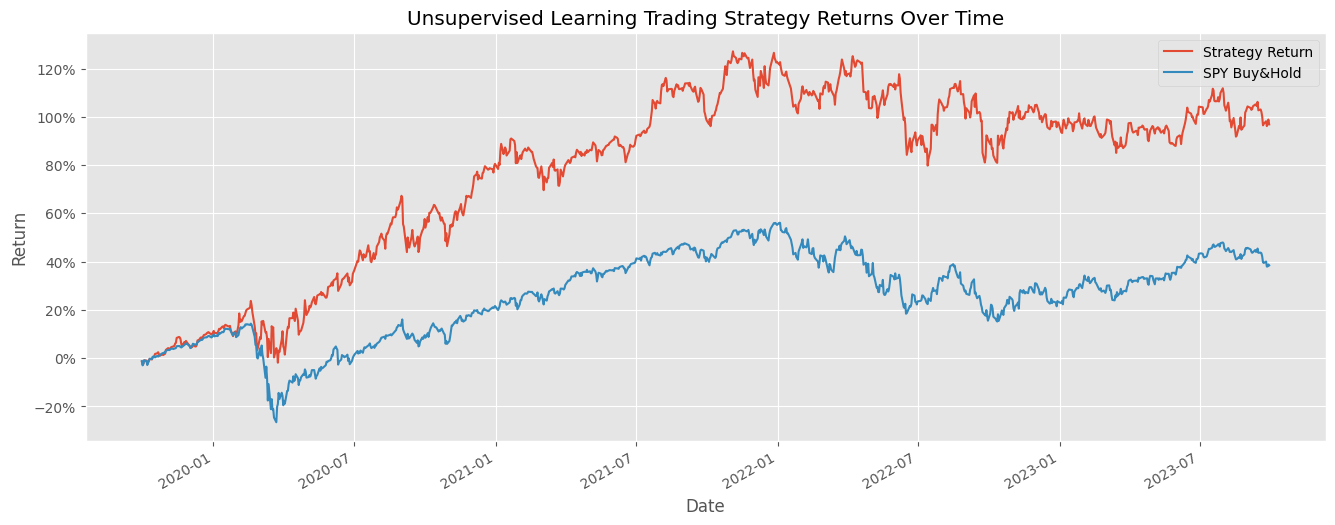

In [157]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [ ]:
gross_rets = (1+portfolio_df['Strategy Return']).cumprod()
bench_rets = (1+portfolio_df['SPY Buy&Hold']).cumprod()

rets = (gross_rets * 1000)
roi = ((rets[-1] - 1000)/1000) * 100
roi

b_rets = (bench_rets * 1000)
b_roi = ((b_rets[-1] - 1000)/1000) * 100
b_roi, roi, rets[-1]

(np.float64(112.83638830735553),
 np.float64(220.29915967704235),
 np.float64(3202.9915967704237))

In [163]:
portfolio_df['Strategy Return'].mean(), portfolio_df['SPY Buy&Hold'].mean()

(np.float64(0.0008977393139795401), np.float64(0.0005901045974132171))

Strategy ROI: 220.30%
Benchmark ROI: 112.84%


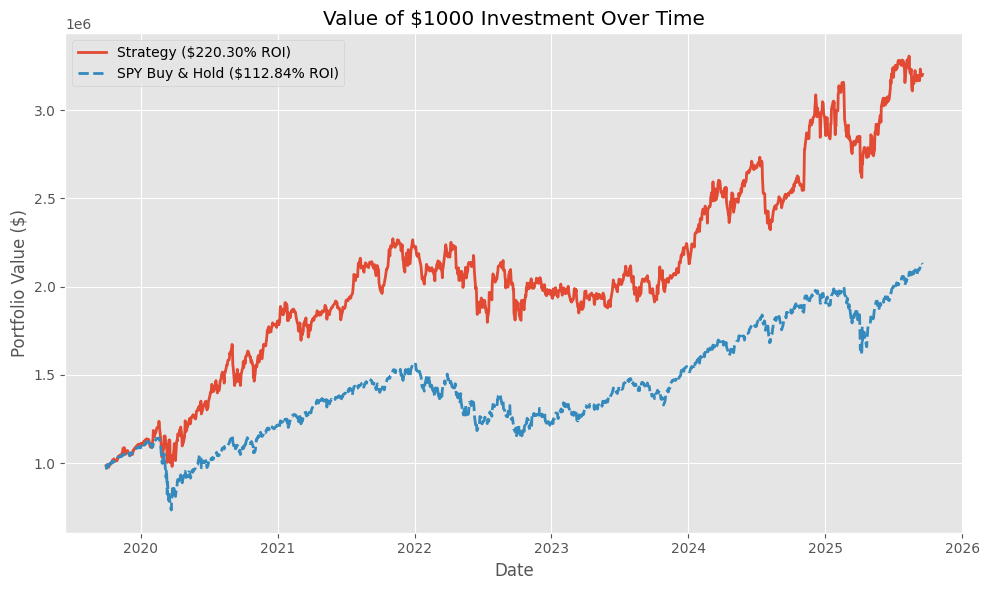

In [161]:
import matplotlib.pyplot as plt

# Calculate cumulative returns
gross_rets = (1 + portfolio_df['Strategy Return']).cumprod()
bench_rets = (1 + portfolio_df['SPY Buy&Hold']).cumprod()

# Calculate investment values starting with $1000
initial_investment = 1000000
rets = gross_rets * initial_investment
b_rets = bench_rets * initial_investment

# Calculate ROI
roi = ((rets.iloc[-1] - initial_investment) / initial_investment) * 100
b_roi = ((b_rets.iloc[-1] - initial_investment) / initial_investment) * 100

# Print ROI
print(f"Strategy ROI: {roi:.2f}%")
print(f"Benchmark ROI: {b_roi:.2f}%")

# Plot both investment values
plt.figure(figsize=(10, 6))
plt.plot(rets, label=f'Strategy (${roi:.2f}% ROI)', linewidth=2)
plt.plot(b_rets, label=f'SPY Buy & Hold (${b_roi:.2f}% ROI)', linestyle='--', linewidth=2)

plt.title('Value of $1000 Investment Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
